In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import yfinance as yf

from snp500 import SNP500
from datetime import datetime as dt
from workflow import WalkForwardStatArb, OUModel, backtest
from workflow.tools.utils import set_plot_style

warnings.filterwarnings("ignore")
set_plot_style()

In [3]:
stocks = [
    "AAPL",   # Apple Inc.
    "MSFT",   # Microsoft Corporation
    "AMZN",   # Amazon.com Inc.
    "GOOGL",  # Alphabet Inc. (Google) - Class A shares
    "META",   # Meta Platforms, Inc. (formerly Facebook)
    "BRK-B",  # Berkshire Hathaway Inc. - Class B shares
    "JNJ",    # Johnson & Johnson
    "V",      # Visa Inc.
    "WMT",    # Walmart Inc.
    "PG",     # Procter & Gamble Co.
    "JPM",    # JPMorgan Chase & Co.
    "NVDA",   # NVIDIA Corporation
    "DIS",    # The Walt Disney Company
    "HD",     # The Home Depot, Inc.
    "MA"      # Mastercard Incorporated
]

etfs = ["SPY", "XLF", "BBH"]

start = "2015-10-11"
end = dt.now()

stock_prices = yf.download(stocks, start, end)["Adj Close"].dropna(axis=1)
etf_prices = yf.download(etfs, start, end)["Adj Close"].reindex(stock_prices.index)

stock_rets = np.log(stock_prices).diff()[1:]
etf_rets = np.log(etf_prices).diff()[1:]

for i in range(len(stock_rets.index)):
    assert stock_rets.index[i] == etf_rets.index[i]

stock_rets.shape, etf_rets.shape

stock_rets.to_csv("workflow/data/stock_rets.csv")
etf_rets.to_csv("workflow/data/etf_rets.csv")

[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  3 of 3 completed


In [3]:
kwargs = {
    "index_col": 0,
    "parse_dates": True
}

stock_returns = pd.read_csv("workflow/data/stock_rets.csv", **kwargs)
etf_returns = pd.read_csv("workflow/data/etf_rets.csv", **kwargs)

stock_returns.shape, etf_returns.shape

((530, 15), (530, 3))

In [4]:
arb_params = {
    "market_returns": etf_returns,
    "stock_returns": stock_returns,
    "lookback": 60,
    "reversion_window": 30
}

arb = WalkForwardStatArb(**arb_params)

In [5]:
arb.run()

Computing s scores...


  0%|          | 0/470 [00:00<?, ?it/s]

Generating signals...


  0%|          | 0/15 [00:00<?, ?it/s]

Determining weights...


  0%|          | 0/470 [00:00<?, ?it/s]

<Axes: xlabel='Date'>

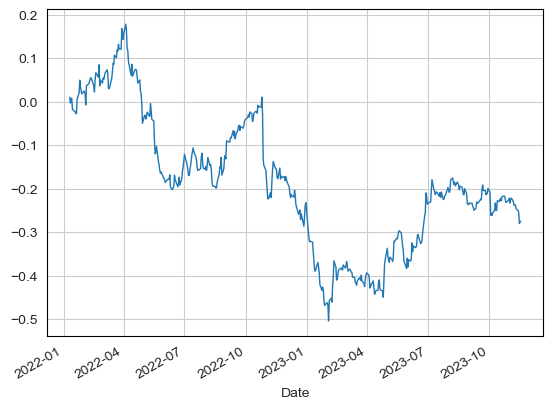

In [11]:
def backtest(weights, returns):
    # Calculate portfolio returns
    port_rets = (weights * returns).sum(axis=1).dropna()

    # Calculate the denominator (average absolute weights)
    denom = (np.abs(weights).sum(axis=1) / 2).reindex(port_rets.index)

    # Replace zeros in the denominator with NaN or another small number
    # to avoid division by zero
    denom_safe = np.where(denom == 0, np.nan, denom)

    # Calculate the final return, handling division by zero
    final_rets = port_rets / denom_safe

    return final_rets.dropna()

backtest(arb.weights, arb.returns).cumsum().plot()

In [152]:
from sklearn.decomposition import PCA

eigenportfolios = []

for i in range(60, len(stock_returns)):
    tmp = stock_returns.iloc[i-60:i]
    pca = PCA(n_components=10).fit(tmp) 
    weights = (pca.components_ / np.std(tmp).values)
    eigenportfolios.append(((pca.components_ / np.std(tmp).values) @ tmp.T).T.values[-1])

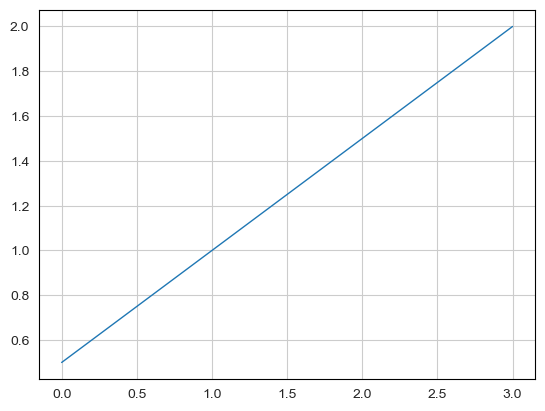

In [163]:
plt.plot(np.array([.5, 1, 1.5, 2]))

In [159]:
pca.components_ / np.std(tmp).values

array([[-1.85708626e+01, -2.16529214e+01, -1.30801502e+01,
        -8.64189040e+00, -2.10557052e+01, -1.56876640e+01,
        -5.70912977e+00, -8.45110914e+00, -1.71195851e+01,
        -2.22868686e+01, -1.74193433e+01, -2.14024189e+01,
        -2.54551919e+00, -1.32447226e+01, -4.41963251e+00],
       [-2.10336108e+00,  1.25544747e+01, -3.07464561e+01,
        -3.88650833e+01,  4.75779185e+00, -2.03428754e+01,
        -2.57890119e+01, -3.33662924e+01, -1.97358729e+01,
         9.82865139e+00, -4.20201773e+00,  8.58682207e+00,
        -1.33421073e+01, -2.34238097e+01,  4.25037186e-01],
       [-3.70449752e+00, -5.10408839e+00, -1.10528552e+01,
         3.32870172e+01,  1.17010055e+01, -2.24122413e+01,
        -1.84777249e+01, -7.92539572e+00, -2.30143497e+01,
         2.66276728e+00, -1.48582027e+01,  1.26694485e+01,
        -2.54936312e+01, -3.15480314e+01, -2.93722981e+01],
       [ 1.69245743e+01, -2.27200099e+01,  4.87415095e+00,
        -2.03041422e+01, -5.59891179e+00,  3.50864057

In [154]:
pca_comps = pd.DataFrame(np.stack(eigenportfolios), index=stock_returns.index[60:]).shift().dropna()
sr = stock_rets.reindex(pca_comps.index)

In [155]:
arb2_params = {
    "market_returns": pca_comps,
    "stock_returns": sr,
    "lookback": 60,
    "reversion_window": 30
}

arb2 = WalkForwardStatArb(**arb2_params)
arb2.run()

Computing s scores...


  0%|          | 0/409 [00:00<?, ?it/s]

Generating signals...


  0%|          | 0/15 [00:00<?, ?it/s]

Determining weights...


  0%|          | 0/409 [00:00<?, ?it/s]

<Axes: xlabel='Date'>

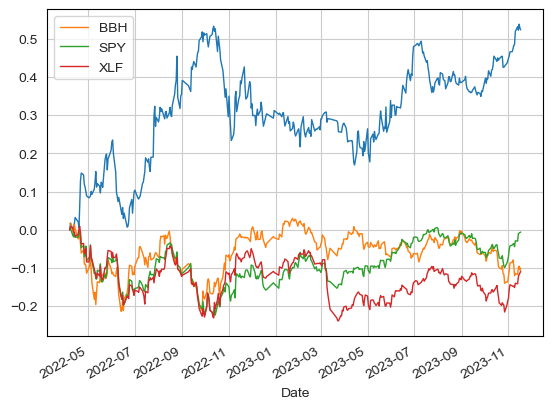

In [157]:
bt = backtest(arb2.weights, arb2.returns).cumsum()

ax = bt.plot()
etf_returns.reindex(bt.index).cumsum().plot(ax=ax)

In [158]:
arb2.weights

,AAPL,AMZN,BRK-B,DIS,GOOGL,HD,JNJ,JPM,MA,META,...,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2022-04-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000455,0.000846,-0.001339,0.002578,0.000302,0.001054,0.002902,-0.000407,-0.001151,-0.002941
2022-04-08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000266,0.000654,-0.001380,0.002442,0.000444,0.001078,0.002792,-0.000451,-0.001394,-0.003021
2022-04-11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000218,0.000604,-0.001461,0.002402,0.000164,0.001082,0.002745,-0.000357,-0.001496,-0.003111
2022-04-12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000248,0.000682,-0.001470,0.002577,0.000104,0.001001,0.002716,-0.000495,-0.001318,-0.003142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,...,0.000387,-0.000004,0.001682,-0.004193,0.000755,0.000968,-0.004312,-0.002711,0.000117,-0.000143
2023-11-14,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,...,0.000131,0.000230,0.001578,-0.004198,0.000608,0.001023,-0.004204,-0.002675,0.000318,-0.000202
2023-11-15,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,...,0.000120,0.000340,0.001184,-0.003971,0.000401,0.000548,-0.004146,-0.002529,-0.000026,-0.000407
